
Logistic Regression classification report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92        91
           1       0.94      0.93      0.93       109

    accuracy                           0.93       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.93      0.93      0.93       200


Decision Tree classification report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        91
           1       0.90      0.95      0.93       109

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200


Random Forest classification report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89        91
           1       0.94      0.87      0.90       109

    accuracy                           0.90       200
   macro

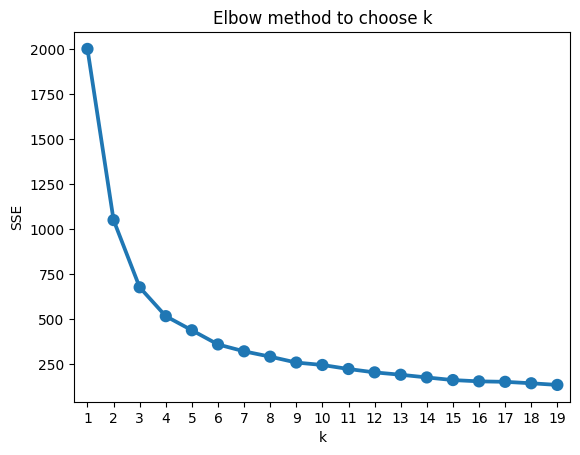


K-means clustering analysis:
           engagement_time engagement_frequency
                      mean                 mean
cluster_id                                     
0                      4.0                  5.0
1                      7.0                 18.0
2                      9.0                  9.0

DBSCAN clustering analysis:
                  engagement_time engagement_frequency
                             mean                 mean
dbscan_cluster_id                                     
-1                           10.0                 20.0
 0                            6.0                 10.0


In [28]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier  # Ensure xgboost is installed
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns
from matplotlib import pyplot as plt

# Specify the file path of your CSV file
file_path = "/Users/bernhardwagner/Documents/Final Project/data/AZWatch_subscribers.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Convert string labels to numerical values
label_mapping = {'churned': 0, 'subscribed': 1}
df['subscription_status'] = df['subscription_status'].map(label_mapping)

# Separate predictor variables from class label
# 'X' will contain all features except 'subscriber_id' and 'subscription_status'
# 'y' will contain the 'subscription_status' which is the target variable
X = df.drop(['subscriber_id', 'subscription_status'], axis=1)
y = df['subscription_status']

# Split the data into training and testing sets (80% train, 20% test)
# Splitting the data helps us to evaluate the model's performance on unseen data, mimicking real-world scenarios
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data processing: Apply One Hot Encoding on the categorical attribute: 'age_group'
# This step converts categorical data into numerical format, which is essential for machine learning algorithms to process the data
X_train_prepared = pd.get_dummies(X_train, columns=['age_group'])
X_test_prepared = pd.get_dummies(X_test, columns=['age_group'])

# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(max_depth=3, criterion="gini"),
    "Random Forest": RandomForestClassifier(n_estimators=10, max_depth=3),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42),
    "XGBoost": XGBClassifier( eval_metric='logloss')
}

# Train and evaluate each model
results = []

for name, model in models.items():
    model.fit(X_train_prepared, y_train)
    y_pred = model.predict(X_test_prepared)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })
    print(f"\n{name} classification report:")
    print(classification_report(y_test, y_pred))

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)
print("\nSummary of model performance:")
print(results_df)

# SUBSCRIBER SEGMENTATION
# Prepare the data for clustering by removing the categorical 'age_group' column
# Clustering is used to identify distinct groups within the subscribers for targeted marketing or other purposes
segmentation = X.drop(['age_group'], axis=1)

# Scale the numerical data attributes to standardize the data
# Standardizing the data ensures that each feature contributes equally to the clustering process
scaler = StandardScaler()
scaler.fit(segmentation)
segmentation_normalized = scaler.transform(segmentation)

# Determine the optimal number of clusters using the elbow method
# The elbow method helps in choosing the appropriate number of clusters by looking at the sum of squared errors (SSE)
sse = {}  # Dictionary to store the sum of squared errors for each value of k
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(segmentation_normalized)
    sse[k] = kmeans.inertia_  # Inertia is the sum of squared distances to the nearest cluster center
    
# Plot the SSE for each value of k to visualize the elbow point
# The "elbow" point indicates the optimal number of clusters
plt.title('Elbow method to choose k')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

# Apply k-means clustering with 3 clusters (chosen based on the elbow method)
# K-means clustering groups similar subscribers together
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit_predict(segmentation_normalized)

# Add cluster labels as a new attribute in the dataset before scaling
segmentation["cluster_id"] = kmeans.labels_

# Analyze the average feature values and counts per cluster
# Grouping by 'cluster_id' and calculating mean values helps understand the characteristics of each cluster
analysis = segmentation.groupby(['cluster_id']).agg({
    'engagement_time': ['mean'],
    'engagement_frequency': ['mean']
}).round(0)
print("\nK-means clustering analysis:")
print(analysis)

# ADDITIONAL CLUSTERING METHOD: DBSCAN
# DBSCAN clustering to identify clusters based on density
# DBSCAN is effective for datasets with noise and clusters of varying shapes
db = DBSCAN(eps=0.5, min_samples=5).fit(segmentation_normalized)
labels = db.labels_

# Add DBSCAN cluster labels (including noise points labeled as -1) to the segmentation DataFrame
segmentation['dbscan_cluster_id'] = labels

# Analyze the average feature values and counts per DBSCAN cluster
# Grouping by 'dbscan_cluster_id' and calculating mean values helps understand the characteristics of each cluster
dbscan_analysis = segmentation.groupby(['dbscan_cluster_id']).agg({
    'engagement_time': ['mean'],
    'engagement_frequency': ['mean']
}).round(0)
print("\nDBSCAN clustering analysis:")
print(dbscan_analysis)


In [27]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a GradientBoostingClassifier object
gb = GradientBoostingClassifier(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid,
                           scoring='accuracy', cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train_prepared, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

# Train the model with the best parameters
best_gb = grid_search.best_estimator_
best_gb.fit(X_train_prepared, y_train)

# Evaluate the model
y_pred = best_gb.predict(X_test_prepared)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nTuned Gradient Boosting classification report:")
print(classification_report(y_test, y_pred))

# Display the performance
print("\nTuned Gradient Boosting performance:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.9; total time=   0.0s[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.0s

[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END le

/Users/bernhardwagner/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
2187 fits failed out of a total of 6561.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
782 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/bernhardwagner/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/bernhardwagner/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/bernhardwagner/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklear